In [41]:
!which python

/home/user/jfayzullaev/stellar-clustering/.venv-vis/bin/python


In [42]:

import os, pickle, warnings
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)

## Transactions

In [43]:
intr_tx = pd.read_csv("transactions/transaction_spectral_intrinsic_scores.csv").sort_values("k")

In [44]:
print(intr_tx)

      k  silhouette  davies_bouldin  calinski_harabasz
0    10    0.690301        1.485499        4860.376465
1    15    0.709006        1.245287        5418.374436
2    20    0.717137        0.967330        6078.915572
3    30    0.800606        0.702819        6740.407724
4    40    0.859580        0.594412        8155.859739
5    50    0.868196        0.472573       10584.520797
6    65    0.896225        0.639719      101860.090325
7    70    0.861931        0.381088       94598.422508
8    75    0.876426        0.450591       93816.126011
9    80    0.854264        0.653410       82974.697609
10  100    0.843904        0.946688       57897.840760
11  120    0.792340        1.348598       45504.138642
12  150    0.696779   146011.685502       31045.906932
13  180    0.680486   262621.770963       22320.708412
14  210    0.680409   107616.191319       20726.935346
15  250    0.669101   161635.927020       16342.183922
16  300    0.266966   259943.269547       13930.120721
17  350   

k=50–70

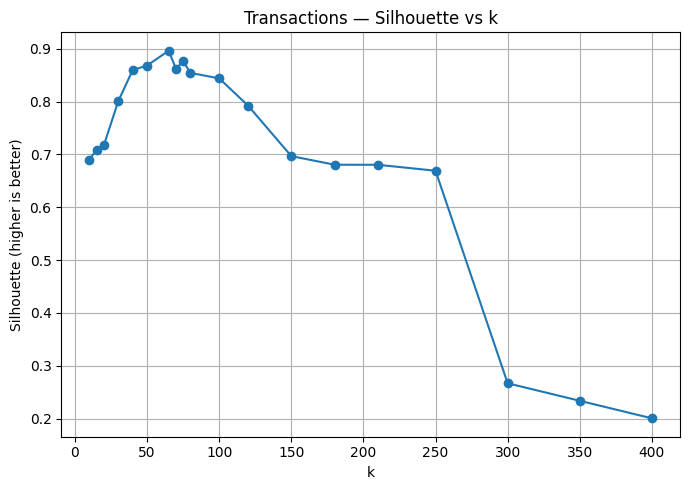

In [45]:
plt.figure(figsize=(7,5))
plt.plot(intr_tx["k"], intr_tx["silhouette"], marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette (higher is better)")
plt.title("Transactions — Silhouette vs k")
plt.grid(True, which="both", axis="both")
plt.tight_layout(); plt.show()

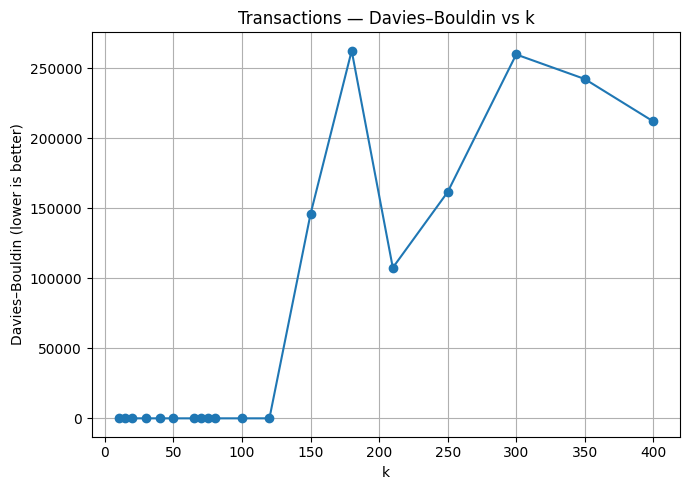

In [46]:
plt.figure(figsize=(7,5))
plt.plot(intr_tx["k"], intr_tx["davies_bouldin"], marker="o")
plt.xlabel("k"); plt.ylabel("Davies–Bouldin (lower is better)")
plt.title("Transactions — Davies–Bouldin vs k")
plt.grid(True, which="both", axis="both")
plt.tight_layout(); plt.show()

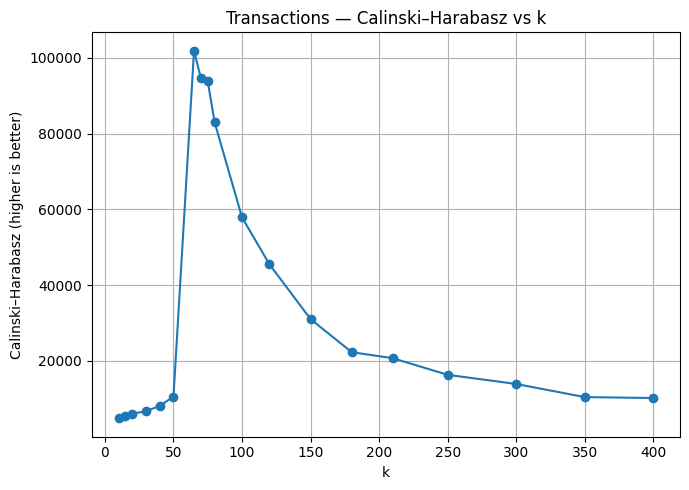

In [47]:
plt.figure(figsize=(7,5))
plt.plot(intr_tx["k"], intr_tx["calinski_harabasz"], marker="o")
plt.xlabel("k"); plt.ylabel("Calinski–Harabasz (higher is better)")
plt.title("Transactions — Calinski–Harabasz vs k")
plt.grid(True, which="both", axis="both")
plt.tight_layout(); plt.show()

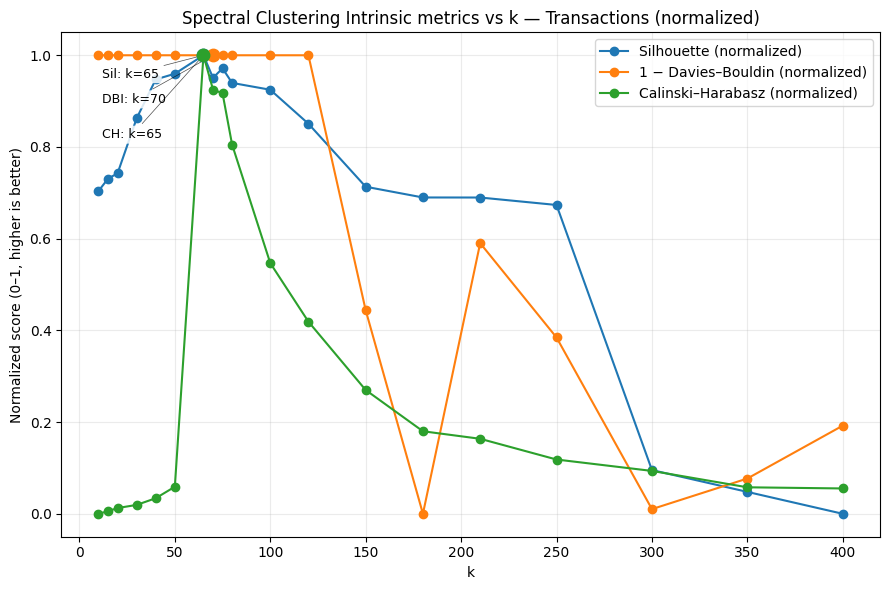

In [48]:
k   = intr_tx["k"].astype(int)
sil = intr_tx["silhouette"]
dbi = intr_tx["davies_bouldin"]
ch  = intr_tx["calinski_harabasz"]

def normalize(series, invert=False):
    s = series.astype(float)
    if invert:
        s = s.max() - s
    mn, mx = s.min(), s.max()
    if mx == mn:
        return np.full_like(s, 0.5, dtype=float)
    return (s - mn) / (mx - mn)

sil_n = normalize(sil, invert=False)
dbi_n = normalize(dbi, invert=True) 
ch_n  = normalize(ch,  invert=False)

k_arr   = k.to_numpy()
sil_arr = sil_n.to_numpy()
dbi_arr = dbi_n.to_numpy()
ch_arr  = ch_n.to_numpy()

best_sil_idx = sil_arr.argmax()
best_dbi_idx = dbi_arr.argmax()
best_ch_idx  = ch_arr.argmax()

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(k_arr, sil_arr, marker="o", label="Silhouette (normalized)")
ax.plot(k_arr, dbi_arr, marker="o", label="1 − Davies–Bouldin (normalized)")
ax.plot(k_arr, ch_arr,  marker="o", label="Calinski–Harabasz (normalized)")

best_sil_idx = sil_arr.argmax()
best_dbi_idx = dbi_arr.argmax()
best_ch_idx  = ch_arr.argmax()

ann_cfg = [
    (best_sil_idx, f"Sil: k={int(k_arr[best_sil_idx])}", sil_arr, (0.05, 0.93)),
    (best_dbi_idx, f"DBI: k={int(k_arr[best_dbi_idx])}", dbi_arr, (0.05, 0.88)),
    (best_ch_idx,  f"CH: k={int(k_arr[best_ch_idx])}",  ch_arr,  (0.05, 0.81)),
]

for idx, label, series, (tx, ty) in ann_cfg:
    x_val = k_arr[idx]
    y_val = series[idx]

    ax.scatter([x_val], [y_val], s=80, zorder=5)
    ax.annotate(
        label,
        xy=(x_val, y_val),
        xycoords="data",
        xytext=(tx, ty),
        textcoords="axes fraction",
        ha="left",
        va="top",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.85),
        arrowprops=dict(arrowstyle="-", lw=0.5, alpha=0.7),
    )

ax.set_xlabel("k")
ax.set_ylabel("Normalized score (0–1, higher is better)")
ax.set_title("Spectral Clustering Intrinsic metrics vs k — Transactions (normalized)")
ax.grid(True, which="both", axis="both", alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()


In [49]:
ext_tx = pd.read_csv("transactions/spectral_external_vs_norm.csv").sort_values("k")

In [50]:
display(ext_tx)

,k,NMI_vs_norm,ARI_vs_norm,Purity_vs_norm
0,10,0.160879,0.036050,0.717884
1,15,0.186275,-0.003942,0.717884
2,20,0.191882,-0.017221,0.717884
3,30,0.295649,0.077835,0.727960
4,40,0.298557,0.014002,0.727960
5,50,0.325199,0.061947,0.755668
6,65,0.331543,0.062750,0.758186
7,70,0.331867,0.060974,0.758186
8,75,0.340997,0.028390,0.768262
9,80,0.336649,0.033135,0.763224


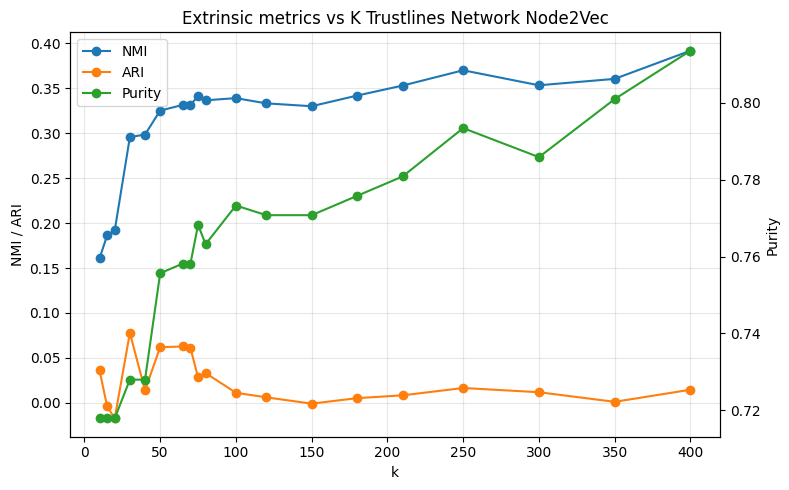

In [ ]:
k = ext_tx["k"].astype(int)
nmi = ext_tx["NMI_vs_norm"]
ari = ext_tx["ARI_vs_norm"]
pur = ext_tx["Purity_vs_norm"]

fig, ax1 = plt.subplots(figsize=(8,5))
ax2 = ax1.twinx()

l1, = ax1.plot(k, nmi, marker="o", label="NMI", color="tab:blue")
l2, = ax1.plot(k, ari, marker="o", label="ARI", color="tab:orange")
l3, = ax2.plot(k, pur, marker="o", label="Purity", color="tab:green")

ax1.set_xlabel("k")
ax1.set_ylabel("NMI / ARI")
ax2.set_ylabel("Purity")

ax1.grid(True, alpha=0.3)
ax1.legend([l1, l2, l3], ["NMI", "ARI", "Purity"], loc="best")
plt.title("Extrinsic metrics vs K Trustlines Network Node2Vec")
plt.tight_layout()
plt.show()

k=20, k=50, and k=65

k ≈ 50–70, with k=65

## Trustline

In [51]:
intr_tl = pd.read_csv("trustlines/trustlines_spectral_intrinsic_scores.csv").sort_values("k")

In [52]:
print(intr_tl)

      k  silhouette  davies_bouldin  calinski_harabasz
0    10    0.056350        2.112132          83.618176
1    15   -0.032298        1.313443          88.280097
2    20    0.718873        0.693474         354.498008
3    30    0.233321        0.767132         316.288507
4    40    0.073824        0.687931         579.717035
5    50    0.621891        0.416456        1036.669604
6    65    0.770930        0.323895       12082.182510
7    70   -0.114789        0.331668       13030.664366
8    75   -0.208066        0.413489       10461.492402
9    80   -0.186362        0.423366        9751.077012
10  100   -0.346748        0.744887        7114.200480
11  120   -0.436572        1.028619        4853.234995
12  150   -0.584616        1.014565        4319.296999
13  180   -0.605919        1.115651        3593.148543
14  210   -0.644052        1.428358        3192.090528
15  250   -0.682612        1.468779        2379.785646
16  300   -0.690670        1.770429        2041.459989
17  350   

k ≈ 50–65

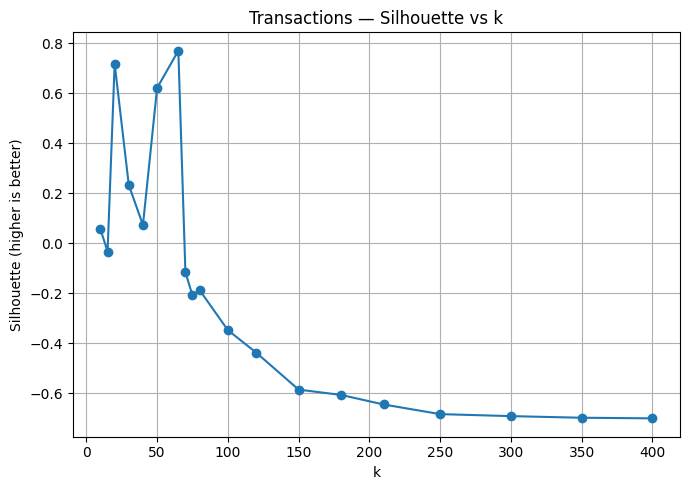

In [53]:
plt.figure(figsize=(7,5))
plt.plot(intr_tl["k"], intr_tl["silhouette"], marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette (higher is better)")
plt.title("Transactions — Silhouette vs k")
plt.grid(True, which="both", axis="both")
plt.tight_layout(); plt.show()

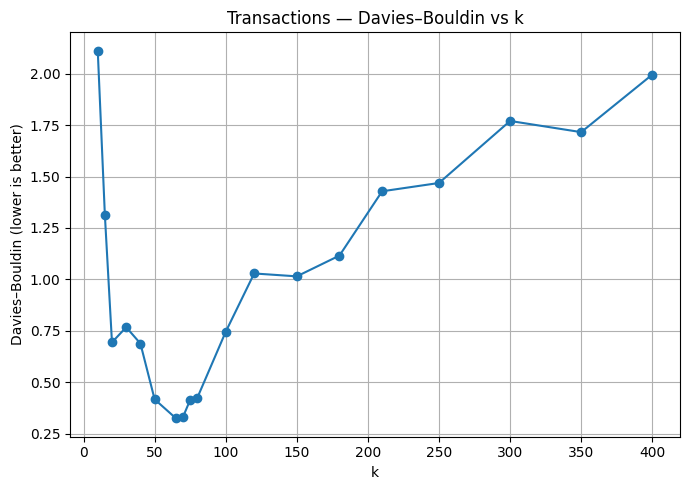

In [54]:
plt.figure(figsize=(7,5))
plt.plot(intr_tl["k"], intr_tl["davies_bouldin"], marker="o")
plt.xlabel("k"); plt.ylabel("Davies–Bouldin (lower is better)")
plt.title("Transactions — Davies–Bouldin vs k")
plt.grid(True, which="both", axis="both")
plt.tight_layout(); plt.show()

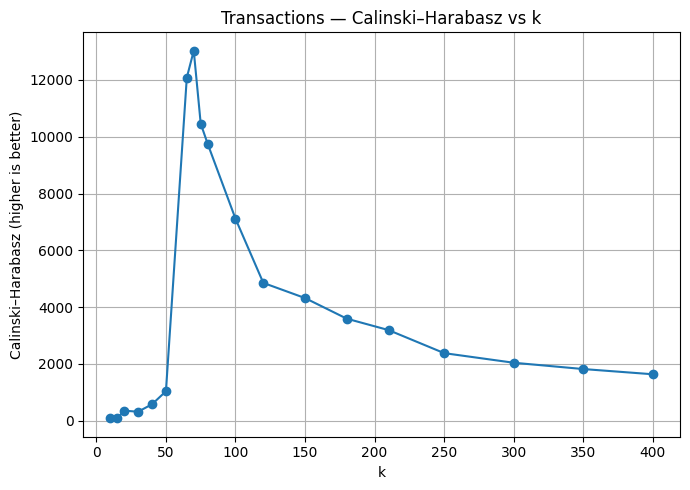

In [55]:
plt.figure(figsize=(7,5))
plt.plot(intr_tl["k"], intr_tl["calinski_harabasz"], marker="o")
plt.xlabel("k"); plt.ylabel("Calinski–Harabasz (higher is better)")
plt.title("Transactions — Calinski–Harabasz vs k")
plt.grid(True, which="both", axis="both")
plt.tight_layout(); plt.show()

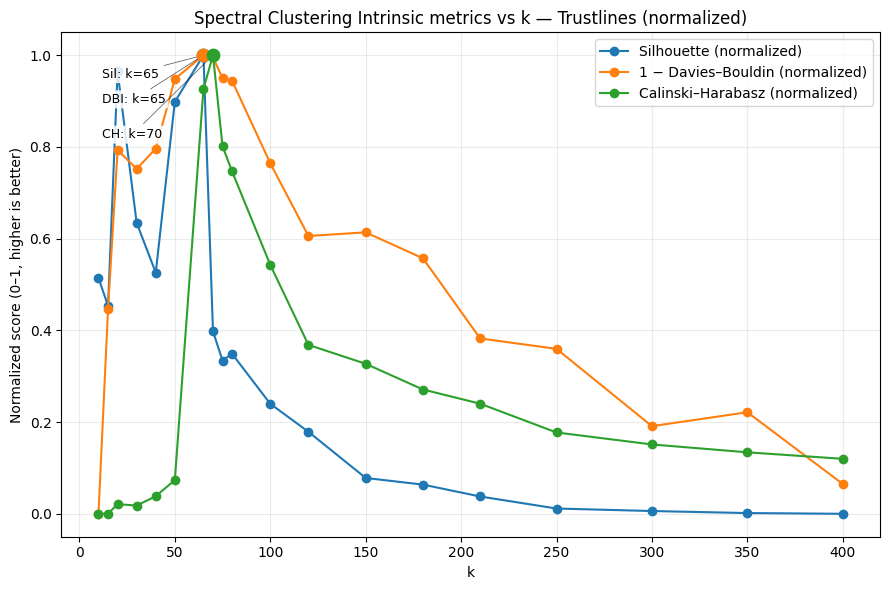

In [56]:
k   = intr_tl["k"].astype(int)
sil = intr_tl["silhouette"]
dbi = intr_tl["davies_bouldin"]
ch  = intr_tl["calinski_harabasz"]

def normalize(series, invert=False):
    s = series.astype(float)
    if invert:
        s = s.max() - s
    mn, mx = s.min(), s.max()
    if mx == mn:
        return np.full_like(s, 0.5, dtype=float)
    return (s - mn) / (mx - mn)

sil_n = normalize(sil, invert=False)
dbi_n = normalize(dbi, invert=True) 
ch_n  = normalize(ch,  invert=False)

k_arr   = k.to_numpy()
sil_arr = sil_n.to_numpy()
dbi_arr = dbi_n.to_numpy()
ch_arr  = ch_n.to_numpy()

best_sil_idx = sil_arr.argmax()
best_dbi_idx = dbi_arr.argmax()
best_ch_idx  = ch_arr.argmax()

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(k_arr, sil_arr, marker="o", label="Silhouette (normalized)")
ax.plot(k_arr, dbi_arr, marker="o", label="1 − Davies–Bouldin (normalized)")
ax.plot(k_arr, ch_arr,  marker="o", label="Calinski–Harabasz (normalized)")

best_sil_idx = sil_arr.argmax()
best_dbi_idx = dbi_arr.argmax()
best_ch_idx  = ch_arr.argmax()

ann_cfg = [
    (best_sil_idx, f"Sil: k={int(k_arr[best_sil_idx])}", sil_arr, (0.05, 0.93)),
    (best_dbi_idx, f"DBI: k={int(k_arr[best_dbi_idx])}", dbi_arr, (0.05, 0.88)),
    (best_ch_idx,  f"CH: k={int(k_arr[best_ch_idx])}",  ch_arr,  (0.05, 0.81)),
]

for idx, label, series, (tx, ty) in ann_cfg:
    x_val = k_arr[idx]
    y_val = series[idx]

    ax.scatter([x_val], [y_val], s=80, zorder=5)
    ax.annotate(
        label,
        xy=(x_val, y_val),
        xycoords="data",
        xytext=(tx, ty),
        textcoords="axes fraction",
        ha="left",
        va="top",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.85),
        arrowprops=dict(arrowstyle="-", lw=0.5, alpha=0.7),
    )

ax.set_xlabel("k")
ax.set_ylabel("Normalized score (0–1, higher is better)")
ax.set_title("Spectral Clustering Intrinsic metrics vs k — Trustlines (normalized)")
ax.grid(True, which="both", axis="both", alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()


In [57]:
ext_tl = pd.read_csv("trustlines/trustlines_spectral_external_vs_norm.csv").sort_values("k")

In [58]:
display(ext_tl)

,k,NMI_vs_norm,ARI_vs_norm,Purity_vs_norm
0,10,0.168887,0.139380,0.870504
1,15,0.009577,-0.045283,0.870504
2,20,0.000000,0.000000,0.870504
3,30,0.029616,-0.013486,0.870504
4,40,0.007384,-0.035446,0.870504
5,50,0.082451,0.043224,0.877698
6,65,0.234856,0.243241,0.884892
7,70,0.234856,0.243241,0.884892
8,75,0.086183,0.086383,0.877698
9,80,0.234856,0.243241,0.884892


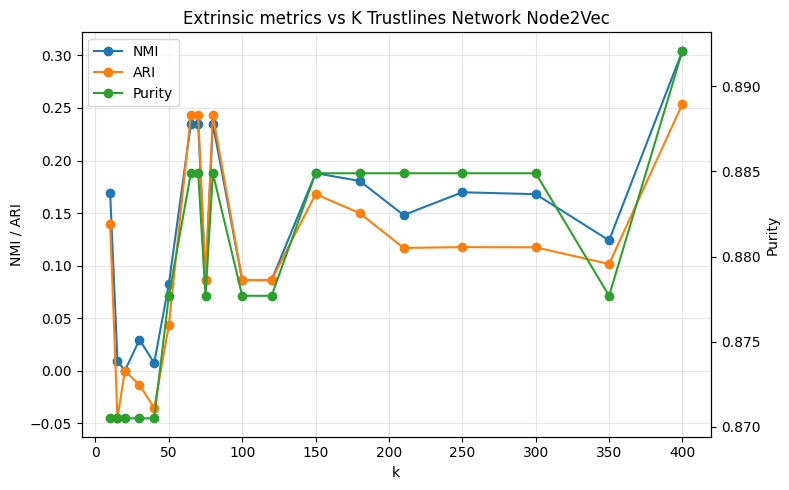

In [64]:
k = ext_tl["k"].astype(int)
nmi = ext_tl["NMI_vs_norm"]
ari = ext_tl["ARI_vs_norm"]
pur = ext_tl["Purity_vs_norm"]

fig, ax1 = plt.subplots(figsize=(8,5))
ax2 = ax1.twinx()

l1, = ax1.plot(k, nmi, marker="o", label="NMI", color="tab:blue")
l2, = ax1.plot(k, ari, marker="o", label="ARI", color="tab:orange")
l3, = ax2.plot(k, pur, marker="o", label="Purity", color="tab:green")

ax1.set_xlabel("k")
ax1.set_ylabel("NMI / ARI")
ax2.set_ylabel("Purity")

ax1.grid(True, alpha=0.3)
ax1.legend([l1, l2, l3], ["NMI", "ARI", "Purity"], loc="best")
plt.title("Extrinsic metrics vs K Trustlines Network Node2Vec")
plt.tight_layout()
plt.show()

k=65

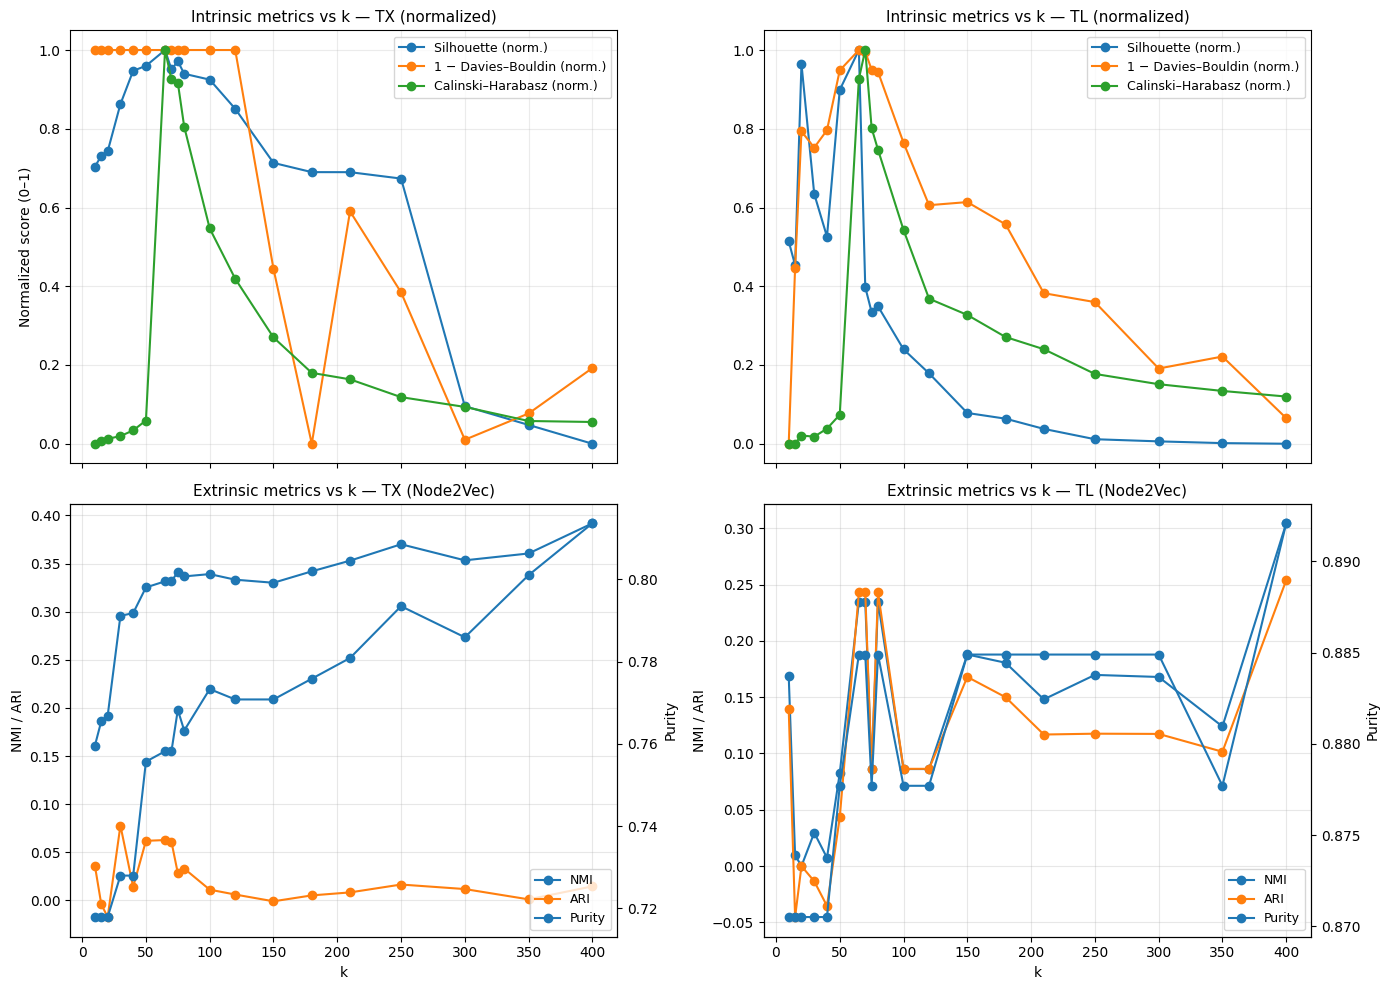

In [75]:
import numpy as np
import matplotlib.pyplot as plt

def normalize(series, invert=False):
    s = series.astype(float)
    if invert:
        s = s.max() - s
    mn, mx = s.min(), s.max()
    if mx == mn:
        return np.full_like(s, 0.5, dtype=float)
    return (s - mn) / (mx - mn)

def plot_internal(ax, intr_df, title):
    k   = intr_df["k"].astype(int)
    sil = intr_df["silhouette"]
    dbi = intr_df["davies_bouldin"]
    ch  = intr_df["calinski_harabasz"]

    sil_n = normalize(sil)
    dbi_n = normalize(dbi, invert=True)
    ch_n  = normalize(ch)

    ax.plot(k, sil_n, marker="o", label="Silhouette (norm.)")
    ax.plot(k, dbi_n, marker="o", label="1 − Davies–Bouldin (norm.)")
    ax.plot(k, ch_n,  marker="o", label="Calinski–Harabasz (norm.)")

    ax.set_title(title, fontsize=11)
    ax.grid(True, which="both", axis="both", alpha=0.25)
    ax.legend(fontsize=9)

def plot_external(ax, ext_df, title):
    k   = ext_df["k"].astype(int)
    nmi = ext_df["NMI_vs_norm"]
    ari = ext_df["ARI_vs_norm"]
    pur = ext_df["Purity_vs_norm"]

    ax2 = ax.twinx()

    l1, = ax.plot(k, nmi, marker="o", label="NMI")
    l2, = ax.plot(k, ari, marker="o", label="ARI")
    l3, = ax2.plot(k, pur, marker="o", label="Purity")

    ax.set_title(title, fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_ylabel("NMI / ARI")
    ax2.set_ylabel("Purity")

    ax.legend([l1, l2, l3], ["NMI", "ARI", "Purity"], loc="lower right", fontsize=9)

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex="col")

plot_internal(axes[0, 0], intr_tx, "Intrinsic metrics vs k — TX (normalized)")
plot_internal(axes[0, 1], intr_tl, "Intrinsic metrics vs k — TL (normalized)")

plot_external(axes[1, 0], ext_tx, "Extrinsic metrics vs k — TX (Node2Vec)")
plot_external(axes[1, 1], ext_tl, "Extrinsic metrics vs k — TL (Node2Vec)")

axes[1, 0].set_xlabel("k")
axes[1, 1].set_xlabel("k")
axes[0, 0].set_ylabel("Normalized score (0–1)")

plt.tight_layout()
plt.show()
